In this notebook we will leverage mlflow to keep track of our experiments and models. MLflow Tracking is organized around the concept of runs, which are executions of some piece of data science code. 

In [15]:
from pathlib import Path
import pandas as pd
import tempfile
from joblib import dump

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import mlflow
from azureml.core import Workspace, Experiment, Run, Model

In [3]:
from templates.experiment_tracking.train_baseline import create_decision_boundary_figure

In [4]:
# Read the data from the file
DATA_DIR = Path("data/")
df_train = pd.read_csv(DATA_DIR/'train.csv')
df_test = pd.read_csv(DATA_DIR/'test.csv')

In [5]:
# We define the hyperparameters we want to tune
param_grid = {
    "n_estimators": [10, 25, 100],
    "criterion": ["gini", "entropy"],
    "max_depth": [2, 5, 10, None],
}
n_cross_vals = 5
print("Hyper-parameters:")
for param, value in param_grid.items():
    print(f"gridsearch-{param}", str(value))

Hyper-parameters:
gridsearch-n_estimators [10, 25, 100]
gridsearch-criterion ['gini', 'entropy']
gridsearch-max_depth [2, 5, 10, None]


<b>MLflow</b> stores the details of a run like logs, code versions, data, and model artifacts. The first thing we need to do is tell MLFlow where to store the logs.

We can do this using a MLFlow tracking URI ([docs](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.set_tracking_uri)). An MLflow tracking uri can be a local directory, database, or mlflow server.

In [6]:
# Check the currect tracking uri.
mlflow.is_tracking_uri_set()

False

The training will be done in this notebook, but the logs will be collected in the clouds.

In AzureML, you can get and set the tracking URI by running:

In [33]:
# Get the AzureML workspace.
workspace = Workspace.from_config()

In [7]:
azure_ws_mlflow_tracking_uri = workspace.get_mlflow_tracking_uri()
print(f"AzureML workspace mlflow uri: {azure_ws_mlflow_tracking_uri}")

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


AzureML workspace mlflow uri: azureml://westeurope.api.azureml.ms/mlflow/v1.0/subscriptions/8e155238-93f7-4377-9b62-6a2f4e51052e/resourceGroups/prashant-srivastava-sandbox/providers/Microsoft.MachineLearningServices/workspaces/azureml-mlflow?


In [8]:
mlflow.set_tracking_uri(azure_ws_mlflow_tracking_uri)
mlflow.get_tracking_uri()

'azureml://westeurope.api.azureml.ms/mlflow/v1.0/subscriptions/8e155238-93f7-4377-9b62-6a2f4e51052e/resourceGroups/prashant-srivastava-sandbox/providers/Microsoft.MachineLearningServices/workspaces/azureml-mlflow?'

We can now create mlflow runs to record our training experiments.
AzureML allows to create mlflow runs as Jobs. These jobs are create under an Experiment namespace.

In [9]:
# Create AzureML Experiment and use it for this run.
# If you do not create an Experiment, AzureML will create a Default experiment for runs.
experiment = Experiment(workspace, 'MyExp')
mlflow.set_experiment('MyExp')

<Experiment: artifact_location='', creation_time=1677754360034, experiment_id='fc4fc279-1c38-4453-ba0f-78aa46c27c1b', last_update_time=None, lifecycle_stage='active', name='MyExp', tags={}>

Starting mlflow run with id 8c967461-05bb-4b4b-8aa2-c61af119c860
Fitting the model...
Done! Test accuracy: 0.97
Logging to mlflow.


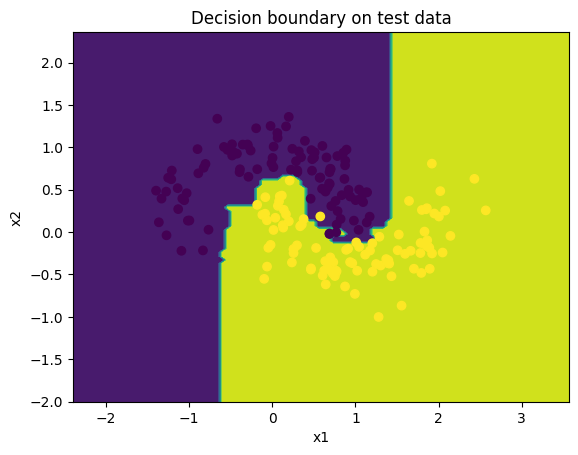

In [10]:
# Start mlflow run
with mlflow.start_run(
    run_name=f"MyTraining"
) as run:
    run_id = run.info.run_id
    print(f"Starting mlflow run with id {run_id}")
    for param, value in param_grid.items():
        mlflow.log_param(f"gridsearch/{param}", str(value))

    model = RandomForestClassifier()
    grid_search = GridSearchCV(model, param_grid, cv=n_cross_vals, n_jobs=-1)

    # We train the model
    print(f"Fitting the model...")
    grid_search.fit(df_train[["x1", "x2"]], df_train["y"])
    model = grid_search.best_estimator_
    
    # Here we evaluate the model
    predictions = model.predict(df_test[["x1", "x2"]])
    test_accuracy = accuracy_score(df_test["y"], predictions)
    print(f"Done! Test accuracy: {test_accuracy}")

    # We log the accuracy to azureml using mlflow
    # You can see the logged metrics in the azureml UI under the "Metrics" tab
    print("Logging to mlflow.")
    mlflow.log_metric("test_accuracy", test_accuracy)

    # We log the selected hyper-parameters to azureml using mlflow
    # You can find the best hyper-parameters in the azureml UI under parameters.
    for k, v in grid_search.best_params_.items():
        mlflow.log_param(f"selected-{k}", v)

    # We log the decision boundary to azureml using mlflow as an image artifact.
    # You can find the image in the azureml UI under images.
    figure = create_decision_boundary_figure(model, df_test, return_figure=False)
    mlflow.log_figure(figure, "decision_boundary.png")
    # Export the model and log it to azureml using mlflow
    with tempfile.TemporaryDirectory() as tmp_dir:
        dump(model, f"{tmp_dir}/model.joblib")
        mlflow.log_artifact(f"{tmp_dir}/model.joblib")

In [25]:
run = Run.get(workspace=workspace, run_id=run_id)
run

Experiment,Id,Type,Status,Details Page,Docs Page
MyExp,8c967461-05bb-4b4b-8aa2-c61af119c860,,Completed,Link to Azure Machine Learning studio,Link to Documentation


We can 

In [14]:
artifact_path = "model.joblib"
model_uri = f"runs:/{run.id}/{artifact_path}"

mlflow.register_model(model_uri=model_uri, name='MyModel')

Successfully registered model 'MyModel'.
2023/03/02 12:37:28 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: MyModel, version 1
Created version '1' of model 'MyModel'.


<ModelVersion: creation_timestamp=1677757048286, current_stage='None', description='', last_updated_timestamp=1677757048286, name='MyModel', run_id='8c967461-05bb-4b4b-8aa2-c61af119c860', run_link='', source='azureml://experiments/MyExp/runs/8c967461-05bb-4b4b-8aa2-c61af119c860/artifacts/model.joblib', status='READY', status_message='', tags={}, user_id='', version='1'>

In [32]:
Model.list(workspace=workspace, name='MyModel')

[Model(workspace=Workspace.create(name='azureml-mlflow', subscription_id='8e155238-93f7-4377-9b62-6a2f4e51052e', resource_group='prashant-srivastava-sandbox'), name=MyModel, id=MyModel:1, version=1, tags={}, properties={'azureml.artifactPrefix': 'ExperimentRun/dcid.8c967461-05bb-4b4b-8aa2-c61af119c860/model.joblib', 'mlflow.modelSourceUri': 'azureml://experiments/MyExp/runs/8c967461-05bb-4b4b-8aa2-c61af119c860/artifacts/model.joblib'})]